# Unpredictability Between Worlds: Graph Replication

This notebook was used to independently replicate the results found in the original paper. 

More specifically, the goal of this notebook is to replicate Figures 1-4 independently of Michael Macy's original analysis.

#### These figures refer are: 

* **Fig 1a**: The effect of social influence on partisan conformity with previous participants.
* **Fig 1b**: The effect of social influence on partisan alignment.
* **Fig 2**: Partisan alignment by world and by survey item
* **Fig 3**: Effect of social influence on the unpredictability of partisan alignment.
* **Fig 4a**: The unpredictability of partisan alignment (correlation of independent preferences vs. influence world preferences).
* **Fig 4b**: The unpredictability of partisan alignment (correlation of the first 10 movers vs. rest in influence worlds).


#### Each of these figures helps address one of the following hypotheses:
* **H1**: Partisan differences will be larger in the worlds with social influence compared to the independence condition.
 * Relevant Figures: 1 & 2
 
* **H2**: The alignment of issues will be less predictable between worlds in the influence condition than in the independence condition.
 * Relevant Figures: 3 & 4

_Authors_: Natalie Tong, and Alex Ruch.

# To Do's
* 1) Add in Confidence Intervals/Standard Errors (Natalie) -- DONE
* 2) Get Michael's original code (Alex), clean data accordingly (Natalie), and clean notebook accordingly (Natalie)
* 3) Ask Michael on how p-value line was calculated in Figure 2 (Natalie)
* 4) Add in Figure 3 Code (Alex)
* 5) Check over Natalie's Existing Code (Alex)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm

%matplotlib inline

## Loading & Pre-processing data

NOTE TO ALEX: This will be deleted once we get the acutal data finalized 

In [2]:
#First, load the individual user data (we will assign new user_id's and we need their political stance)
user_data = pd.read_csv('users_final.csv')


user_data['user_id'] = user_data['mturk'] #Naming this column 'user_id' makes the .join() command easier
                                          #As the same name exists in 'user_data'
user_data['user_key'] = user_data.index   #This will be the true user key used in this analysis ( )

user_data[['user_id','political_stand','user_key']].head()

,user_id,political_stand,user_key
0,5c34e423-8d6e-4a62-b4be-f8755748a2eb,strong Democrats,0
1,5c34ea5d-82ff-4f65-bee8-2ca4eb2848db,Republicans,1
2,5c34f29d-90b0-4c04-b78c-959b16f1c0d6,strong Democrats,2
3,5c34f45d-408d-4388-a655-f44a14991304,strong Democrats,3
4,5c34f905-a310-47cd-bf2b-324cf95e4adb,strong Democrats,4


In [3]:
#Load the answer data, and get extra columns used in later group by's
answer_data = pd.read_csv('answers_final.csv')

#Filter out Irrelevant Rows
answer_data = answer_data[answer_data['world_id'] != 0] #No World Z
answer_data = answer_data.iloc[:,:-2] #Remove false D & R columns

#Join in user_id's and political stance
answer_data = answer_data.join(user_data[['user_id','political_stand','user_key']].set_index('user_id'),on='user_id').reset_index()

#Get Order Grouped By Question & World
within_wq_order = []
q_dict = {q:0 for q in answer_data['question_id'].unique()}
counter_dict = {world:q_dict.copy() for world in sorted((answer_data['world_id'].unique()))}

for i in tqdm(range(len(answer_data))):
    data = answer_data.iloc[i].copy()

    world = data['world_id']
    question = data['question_id']    
    
    counter_dict[world][question] += 1
    within_wq_order += [counter_dict[world][question]]
    
answer_data['within_wq_order'] = within_wq_order

#Re-sort, Filter, & re-name the columns
answer_data = answer_data[['world_id','question_id','within_wq_order','user_key','index','user_political_stand','political_stand']]
answer_data.columns = ['world','question','wq_order','u_order','q_order','response','pol']

#Rename strings into values
answer_data['pol'] = answer_data['pol'].replace({'strong Democrats':-2, 'Democrats':-1,
                                                 'strong Republicans':+2, 'Republicans':+1})
answer_data['response'] = answer_data['response'].replace({'disagree':0, 'agree':1})

answer_data.head(10)

100%|██████████| 47298/47298 [00:28<00:00, 1665.22it/s]


,world,question,wq_order,u_order,q_order,response,pol
0,7,23,1,0,0,0.0,-2.0
1,7,18,1,0,1,0.0,-2.0
2,7,17,1,0,2,1.0,-2.0
3,7,6,1,0,3,1.0,-2.0
4,7,15,1,0,4,0.0,-2.0
5,7,12,1,0,5,0.0,-2.0
6,7,14,1,0,6,1.0,-2.0
7,7,20,1,0,7,1.0,-2.0
8,7,8,1,0,8,0.0,-2.0
9,7,9,1,0,9,0.0,-2.0


In [4]:
#Filter only on Q's 1-20
answer_data = answer_data[answer_data['question'] >= 1]
answer_data = answer_data[answer_data['question'] <= 20]

#Remove 'NaN's in response and politics
answer_data = answer_data.dropna()
 
#Sort by world and question order
answer_data = answer_data.sort_values('wq_order').sort_values(['world','question'])

In [5]:
#Generate a correct "conform", "D", "R", and "winner" columns

D_percent_list = [] #What is the current running % for Democrats
R_percent_list = [] #What is the current running % for Republican

winner_list = [] #Did D's or R's have the higher number (or was it equal?)
conform_col = [] #Did a user's (dis)agreement conform or rebel (or was the %'s equal at the time)

for w in tqdm(sorted(answer_data['world'].unique())):
    world_data = answer_data[answer_data['world'] == w]
    
    for q in sorted(world_data['question'].unique()):
        question_data = world_data[world_data['question'] == q]
        
        D, R = [], []
        
        for i,idx in enumerate(question_data.index):
            row = question_data.loc[idx]
            
            #Get the percent agreement
            D_percent = np.mean(D) if len(D) > 0 else 0.5
            R_percent = np.mean(R) if len(R) > 0 else 0.5

            #If Democrats & Republicans are "tied"
            if D_percent == R_percent:
                conform_col += ['equal']
                winner = 'equal'

            #If Democrats are "winning"
            elif D_percent > R_percent:
                winner = 'democrats'
                if (((row['pol'] < 0) & (row['response'] == 1)) or   #Democrat & Agree
                   ((row['pol'] > 0) & (row['response'] == 0))):     #Republican & Disagree
                    conform_col += ['conform']
                elif (((row['pol'] < 0) & (row['response'] == 0)) or #Democrat & Disagree
                     ((row['pol'] > 0) & (row['response'] == 1))):   #Republican & Agree
                    conform_col += ['rebel']

            #If Republicans are "winning"
            else:                    
                winner = 'republicans'
                if (((row['pol'] < 0) & (row['response'] == 0)) or  #Democrat & Disagree
                    ((row['pol'] > 0) & (row['response'] == 1))):    #Republican & Agree
                    conform_col += ['conform']
                elif (((row['pol'] < 0) & (row['response'] == 1)) or #Democrat & Agree
                     ((row['pol'] > 0) & (row['response'] == 0))):   #Republican & Disagree
                    conform_col += ['rebel']                   

            #Also add in D, R and Winner list
            D_percent_list += [np.mean(D) if len(D) > 0 else 0.5]
            R_percent_list += [np.mean(R) if len(R) > 0 else 0.5]
            winner_list += [winner]
            
            #Add to the running list of responses
            if row['pol'] < 0:
                D += [row['response']]
            else:
                R += [row['response']]
                
#Add in the columns
answer_data['conform'] = conform_col
answer_data['D%'] = D_percent_list
answer_data['R%'] = R_percent_list
answer_data['winner'] = winner_list



100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


In [6]:
answer_data.to_csv('answer_data_final.csv')

## Load the Data

`answer_data_final.csv` is a post-processed dataset - where each row refers to a specific users response.

Any possible identifying information is absent from this dataset.

**Column Descriptions:**
* world: The world the response's owner belongs to
* question: The question/issue the owner is responding to.
* u_order: The owner is the #th *user* to participate in this study (can be used as a unique user identifier)
* q_order: The owner is the #th user to respond to a *question*
* wq_order: The owner is the #th user to respond to a *question within a world*
* response: User's agreement with the question: {1 = Agree, 0 = Disagree}
* pol: User's political party: {-2: Strongly Democrat, -1: Democrat, 0: Neither, +1: Republican, +2 Strongly Republican}
* D%: Current running percentage of Democrat agreement (before response's owner answers).
* R%: Current running percentage of Republican agreement (before response's owner answers).
* winner: Whether Republicans or Democrats are currently winning or equal: {'republicans', 'democrats', 'equal'}
* conform: Whether the user conformed with their party: {'conform','rebel','equal'}
  * Conforming = user agrees when their party is the winner or disagrees when their party is not the winner


In [7]:
answer_data.from_csv('answer_data_final.csv')
answer_data.head()

,world,question,wq_order,u_order,q_order,response,pol,conform,D%,R%,winner
37,1,1,1,1,37,0.0,1.0,equal,0.5,0.500000,equal
280,1,1,2,14,280,1.0,1.0,rebel,0.5,0.000000,democrats
342,1,1,3,20,342,0.0,-1.0,equal,0.5,0.500000,equal
669,1,1,4,36,669,0.0,2.0,rebel,0.0,0.500000,republicans
783,1,1,5,41,783,0.0,1.0,rebel,0.0,0.333333,republicans


## Figure 1A: 
**_The effect of social influence on partisan conformity with previous participants._**

*The figure reports the proportion of responses that conformed with the majority of previous participants from the same party, broken down by party (blue for Democrats and red for Republicans), strength of party identification (color intensity) and treatment condition. The proportions are scaled relative to an even chance of conforming (Y=0) and the four categories are exclusive. First-movers and other participants who saw equal support from both parties were not included. 95% confidence intervals are adjusted for repeated measures. Conformity was almost at chance among Democrats in the independence condition but not Republicans, indicating greater intrinsic Republican ideological appeal/aversion. In the influence condition, Republicans remained more likely to conform than were Democrats, especially those with a strong party identity.*

In [93]:
'''
First, we'll need to get the % of times a users of each political affiliation conformed in the independence condition
'''

#Select only independence worlds 1 & 2
ind_data = answer_data[answer_data['world'] <=2].copy()

#Next, get total # of responses & # of conforms for each political affiliation
ind_data = ind_data[ind_data['conform'] != 'equal'].groupby(['pol']).count()[['world']].join(
                ind_data[ind_data['conform'] == 'conform'].groupby(['pol']).count()[['question']])
ind_data.columns = ['total','conform'] #Name the columns for clarity

#Get the percentage conform for each partisan affiliation
ind_data['conf'] = ind_data['conform'] / ind_data['total'] - 0.5

ind_data.head()

,total,conform,conf
pol,,,
-2.0,2137,1013,-0.025971
-1.0,1806,851,-0.028793
1.0,2482,1331,0.036261
2.0,1970,1116,0.066497


In [94]:
'''
Next, we'll need to get the % of times a users of each political affiliation conformed in the influence condition
'''

#Select only influence worlds 3-10
inf_data = answer_data[answer_data['world'] > 2].copy()

#Next, get total # of responses & # of conforms for each political affiliation
inf_data = inf_data[inf_data['conform'] != 'equal'].groupby(['pol']).count()[['world']].join(
                inf_data[inf_data['conform'] == 'conform'].groupby(['pol']).count()[['question']])
inf_data.columns = ['total','conform']

#Get the percentage conform for each partisan affiliation
inf_data['conf'] = inf_data['conform'] / inf_data['total'] - 0.5

inf_data.head()

,total,conform,conf
pol,,,
-2.0,8159,5034,0.116987
-1.0,8222,4781,0.081489
1.0,10278,6349,0.117727
2.0,7028,4728,0.172738


In [95]:
'''
Get function for confidence intervals for (strength of) party affiliation by influence/independence condition
'''

import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    '''
    Credit to shashan from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    for this function
    '''
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m-h-.5, m+h-.5 #subtract .5 from each to mean center it

def get_intervals_byparty(full_data, party):
    '''
    Data = Conform column
    Party = a # corresponding to the respective party
    '''
    data_edit = full_data[full_data['conform'] != 'equal']
    data_edit = data_edit[data_edit['pol'] == party] 
    data_edit = data_edit.replace({'rebel':0,'conform':1})

    return mean_confidence_interval(data_edit['conform'])

#Get 95% conf intervals for independent world parties
ind_data_all = answer_data[answer_data['world'] <= 2].copy()
ind_intervals = [get_intervals_byparty(ind_data_all,p) for p in [-2,-1,1,2]]

#Get 95% conf intervals for influence world parties
inf_data_all = answer_data[answer_data['world'] > 2].copy()
inf_intervals = [get_intervals_byparty(inf_data_all,p) for p in [-2,-1,1,2]]

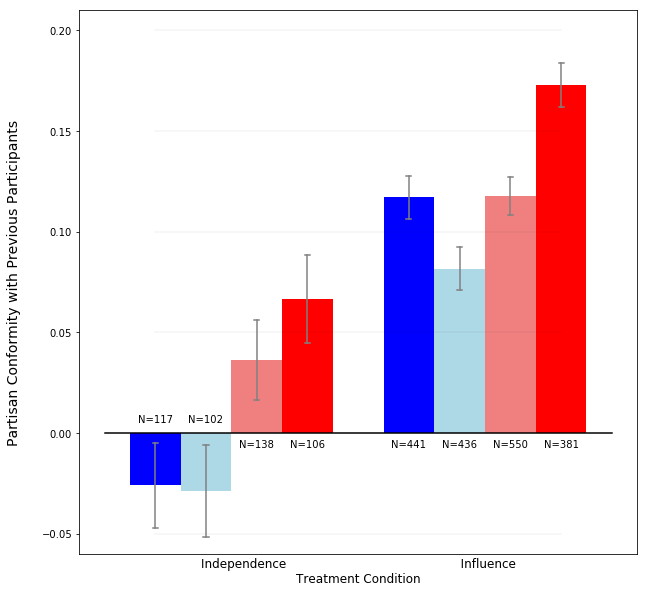

In [105]:
'''
Now let's plot the results.
'''

plt.figure(figsize = (10,10))

#Plot y=0 & y-axis grid lines
plt.plot(np.arange(-1,10),[0]*11,'k')
for i in np.arange(-.5,2.5,.5):
    plt.plot(np.arange(9),[i * 0.1]*9,'k',alpha=.04)

#Plot Strong Democrat Bars
plt.bar(range(9), 
        [ind_data.loc[-2,'conf']] + [0]*4 + [inf_data.loc[-2,'conf']] + [0]*3,
        color='blue', width=1)
#Plot Democrat Bars
plt.bar(range(9), 
        [0]*1 + [ind_data.loc[-1,'conf']] + [0]*4 + [inf_data.loc[-1,'conf']] + [0]*2,
        color = 'lightblue', width=1)
#Plot Republican Bars
plt.bar(range(9), 
        [0]*2 + [ind_data.loc[+1,'conf']] + [0]*4 + [inf_data.loc[+1,'conf']] + [0]*1,
        color = 'lightcoral', width=1)
#Plot Strong Republican Bars
plt.bar(range(9), 
        [0]*3 + [ind_data.loc[+2,'conf']] + [0]*4 + [inf_data.loc[+2,'conf']],
        color = 'red', width=1)

#Plot N size text for each bar at y = +/-0.005
plt.text(0,.005,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == -2)]['u_order']))),
         horizontalalignment='center')
plt.text(1,.005,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == -1)]['u_order']))),
         horizontalalignment='center')
plt.text(2,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == +1)]['u_order']))),
         horizontalalignment='center')
plt.text(3,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] <=2) & (answer_data['pol'] == +2)]['u_order']))),
         horizontalalignment='center')
plt.text(5,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == -2)]['u_order']))),
         horizontalalignment='center')
plt.text(6,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == -1)]['u_order']))),
         horizontalalignment='center')
plt.text(7,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == +1)]['u_order']))),
         horizontalalignment='center')
plt.text(8,-.007,
         'N='+str(len(set(answer_data[(answer_data['world'] >2) & (answer_data['pol'] == +2)]['u_order']))),
         horizontalalignment='center')

#Plot confidence Intervals
for i,(int_start, int_end) in enumerate(ind_intervals):
    plt.plot([i,i],[int_start,int_end],color='gray')
    plt.plot([i-.05,i+.05],[int_end,int_end],color='gray')
    plt.plot([i-.05,i+.05],[int_start,int_start],color='gray')

for i,(int_start, int_end) in enumerate(inf_intervals):
    plt.plot([i+5,i+5],[int_start,int_end],color='gray')
    plt.plot([i+4.95,i+5.05],[int_end,int_end],color='gray')
    plt.plot([i+4.95,i+5.05],[int_start,int_start],color='gray')

#Set Plot Size & Ticks
plt.ylim(-.06,0.21)
plt.xticks([-5])

#Set Labels
plt.ylabel('Partisan Conformity with Previous Participants\n', size = 14)
plt.xlabel('Independence                                             Influence\nTreatment Condition', size = 12)

plt.show()


** Original Figure (For Comparison)**

<img src="results_duplicate_img/fig1a.png" alt="Drawing" style="width: 700px;"/>

## Figure 1B
**_The effect of social influence on partisan alignment._**

*Influence from previous participants in turn led to stronger partisan alignment in the influence condition compared to the independence condition, especially among participants with strong party identification. Alignment is measured as the mean proportion of Democrats who agree on an item in a specific world minus the proportion of Republicans who agree, with the absolute values averaged over 20 items and all worlds in the independence or influence condition. Regardless of the strength of party identification, the differences of opinion between the parties were nearly three times as large in the influence condition (.21 and .29) compared to the independence condition (.08 and .11).*

In [26]:
'''
This time, we are comparing the mean percentage of agreement by question # and political strength in the 
independence/influence worlds. Let's start with the independence condition.
'''

#Let's first select on independence worlds.
ind_str_data = answer_data[answer_data['world'] <=2].copy()

#Get the total # of agrees and overall responses in each ideology-world-question
ind_str_data = ind_str_data[ind_str_data['response'] == 1].groupby(['pol','world','question']).count()[['u_order']].join(
               ind_str_data.groupby(['pol','world','question']).count()[['wq_order']])
ind_str_data.columns = ['agree','total'] #Rename columns for clarity

#Get percent agreement for each ideology-world-question combination
ind_str_data['%agree'] = ind_str_data['agree'] / ind_str_data['total']

ind_str_data

agree  total    %agree
pol  world question                        
-2.0 1     1            30     63  0.476190
           2            17     65  0.261538
           3            16     64  0.250000
           4            35     62  0.564516
           5            45     63  0.714286
           6            43     63  0.682540
           7            24     64  0.375000
           8            22     64  0.343750
           9            39     63  0.619048
           10           30     63  0.476190
           11           23     62  0.370968
           12           35     66  0.530303
           13           32     63  0.507937
           14           34     64  0.531250
           15           40     64  0.625000
           16           49     63  0.777778
           17           17     63  0.269841
           18           20     62  0.322581
           19           23     65  0.353846
           20           50     62  0.806452
     2     1            24     43  0.558140
           2            14     45  0.311111
           3            15     45  0.333333
           4            25     48  0.520833
           5            34     47  0.723404
           6            29     45  0.644444
           7            15     44  0.340909
           8            16     48  0.333333
           9            29     45  0.644444
           10           20     44  0.454545
...                    ...    ...       ...
 2.0 1     11           23     49  0.469388
           12           17     49  0.346939
           13           21     49  0.428571
           14           16     48  0.333333
           15           26     48  0.541667
           16           21     50  0.420000
           17           12     49  0.244898
           18           12     49  0.244898
           19           19     49  0.387755
           20           42     48  0.875000
     2     1            22     52  0.423077
           2             9     51  0.176471
           3            10     51  0.196078
           4            19     52  0.365385
           5            38     52  0.730769
           6            32     53  0.603774
           7            13     53  0.245283
           8            14     50  0.280000
           9            34     53  0.641509
           10           25     52  0.480769
           11           28     50  0.560000
           12           35     51  0.686275
           13           21     51  0.411765
           14           16     51  0.313725
           15           32     51  0.627451
           16           28     51  0.549020
           17            9     51  0.176471
           18           17     52  0.326923
           19           20     51  0.392157
           20           46     52  0.884615

[160 rows x 3 columns]

In [38]:
ind_str_data.loc[-1,w].loc[1]


agree      9.000000
total     37.000000
%agree     0.243243
Name: 1, dtype: float64

In [40]:
'''
Next, for each world-question pair, we can calculate the absolute partisan difference at the weak and strong levels.
We can then get the mean absolute partisan difference across all world-question pairs
'''

#These lists will contain the absolute partisan difference for each world/question pair
ind_weak = []
ind_strong = []

for w in [1,2]: #Only worlds 1-2 (Independence)
    for q in range(1,21):
        #Partisan Difference = |% Weak/Strong Democrat Agree - % Weak/Strong Republican Agree|
        ind_weak += [abs(ind_str_data.loc[-1,w].loc[q]['%agree'] - ind_str_data.loc[+1,w].loc[q]['%agree'])]
        ind_strong += [abs(ind_str_data.loc[-2,w].loc[q]['%agree'] - ind_str_data.loc[+2,w].loc[q]['%agree'])]

#Check how the means look
print(np.mean(ind_weak))
print(np.mean(ind_strong))

0.0759095711601
0.100730334817


In [41]:
'''
Now repeat the above for the influence condition
'''
#Let's select on Influence worlds.
inf_str_data = answer_data[answer_data['world'] > 2]

#Get the total # of agrees and overall responses in each ideology-world-question
inf_str_data = inf_str_data[inf_str_data['response'] == 1].groupby(['pol','world','question']).count()[['u_order']].join(
               inf_str_data.groupby(['pol','world','question']).count()[['wq_order']])
inf_str_data.columns = ['agree','total']

#Get percent agreement for each ideology-world-question combination
inf_str_data['%agree'] = inf_str_data['agree'] / inf_str_data['total']

inf_str_data.head()

agree  total    %agree
pol  world question                        
-2.0 3     1            26     61  0.426230
           2            23     57  0.403509
           3            32     60  0.533333
           4            35     58  0.603448
           5            45     58  0.775862

In [42]:
'''
Now get the mean absolute partisan difference of each world-question pair for the influence condition
'''
#These lists will contain the absolute partisan difference for each world/question pair
inf_weak = []
inf_strong = []

for w in range(3,11): #Influence Worlds
    for q in range(1,21):
        #Partisan Difference = |% Weak/Strong Democrat Agree - % Weak/Strong Republican Agree|
        inf_weak += [abs(inf_str_data.loc[-1,w].loc[q]['%agree'] - inf_str_data.loc[+1,w].loc[q]['%agree'])]
        inf_strong += [abs(inf_str_data.loc[-2,w].loc[q]['%agree'] - inf_str_data.loc[+2,w].loc[q]['%agree'])]
        
#Check how the means look        
print(np.mean(inf_weak))
print(np.mean(inf_strong))

0.211089578049
0.294001048056


In [118]:
def mean_confidence_interval(data, confidence=0.95):
    '''
    Credit to shashan from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    for this function
    '''
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m-h, m+h

ind_interval = [mean_confidence_interval(cond_party) for cond_party in [ind_weak,ind_strong]]
inf_interval = [mean_confidence_interval(cond_party) for cond_party in [inf_weak,inf_strong]]
ind_interval+inf_interval

[(0.054078931287268941, 0.097740211032982874),
 (0.077686993368500976, 0.12377367626601722),
 (0.19548737516963435, 0.22669178092848694),
 (0.27607774589987677, 0.31192435021134546)]

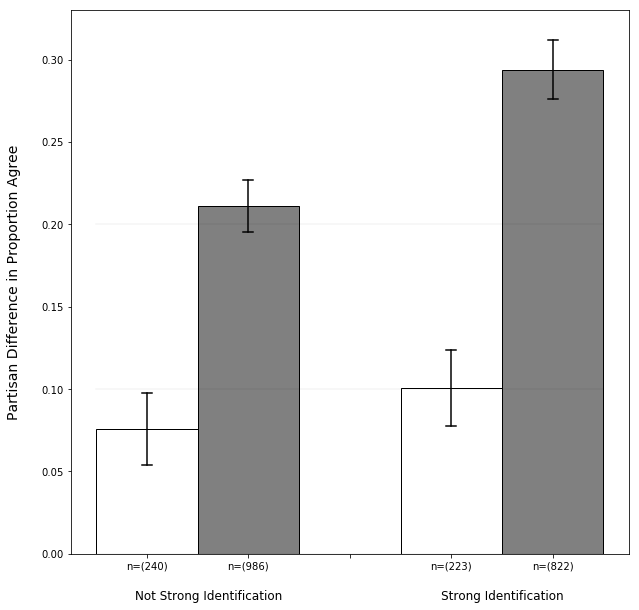

In [128]:
'''
Let's plot Figure 1b!
'''
plt.figure(figsize =(10,10))

#Plot gridlines
for i in range(0,3):
    plt.plot(np.arange(-0.5,5.,0.5),[i * 0.1]*11,'k',alpha=.04)
    
#Plot independence-condition mean absolute partisan differences (weak & strong)
plt.bar(range(5), 
        [np.mean(ind_weak)] + 
        [0]*2 + 
        [np.mean(ind_strong)] + 
        [0],
        color='white', width=1, linewidth=1, edgecolor='k', 
        #Input n-sizes
        tick_label=['n=('+str(len(set(answer_data[(answer_data['world']<=2) & (answer_data['pol'].apply(lambda x: abs(x) == 1))]['u_order']))) + ')',
                    'n=('+str(len(set(answer_data[(answer_data['world']>2) & (answer_data['pol'].apply(lambda x: abs(x) == 1))]['u_order']))) + ')',
                    '',
                    'n=('+str(len(set(answer_data[(answer_data['world']<=2) & (answer_data['pol'].apply(lambda x: abs(x) == 2))]['u_order']))) + ')',
                    'n=('+str(len(set(answer_data[(answer_data['world']>2) & (answer_data['pol'].apply(lambda x: abs(x) == 2))]['u_order']))) + ')'])

#Plot influence-condition mean absolute partisan differences (weak & strong)
plt.bar(range(5), 
        [0] + 
        [np.mean(inf_weak)] + 
        [0]*2 + 
        [np.mean(inf_strong)],
        color='grey', width=1, linewidth=1, edgecolor='k')

#Plot confidence Intervals
order = [0,3,1,4]
for i,(int_start, int_end) in enumerate(ind_interval+inf_interval):
    plt.plot([order[i],order[i]],[int_start,int_end],color='k')
    plt.plot([order[i]-.05,order[i]+.05],[int_end,int_end],color='k')
    plt.plot([order[i]-.05,order[i]+.05],[int_start,int_start],color='k')

#Set Axes Sizes
plt.ylim(0,0.33)

#get Labels
plt.ylabel('Partisan Difference in Proportion Agree\n', size = 14)
plt.xlabel('\nNot Strong Identification                                         Strong Identification', size = 12)

plt.show()


** Original Figure (For Comparison)**

<img src="results_duplicate_img/fig1b.png" alt="Drawing" style="width: 700px;"/>

## Figure 2

**_Partisan alignment by world and by survey item._**

_The Y-axis measures partisan alignment as the proportion of Democrats who supported an issue (in blue) minus the proportion of Republicans (in red). (Issue content by issue number is available in the SOM Table S2.) Dashed lines demarcate the boundaries of statistical significance at P < .001. The parties did not differ significantly on any issues in the independence worlds (1 and 2). In the influence worlds (3-10), substantively unrelated issues became linked into party-specific profiles, much like the “culture wars” in our own world. For example, in world 3, Republican majorities agreed and Democrats opposed the items on great books (15), obedience (19), and gas engines (20), while Democrats agreed and Republicans opposed items on robot lawyers (3), licensed jurors (7), and group loyalty (13)._

In [44]:
'''
The goal is to plot each (non-absolute) partisan difference in each world-question pair.
'''

#Let's create a copy of our data, with a binarized political column (Removing strength of alignment)
wq_data = answer_data.copy()
wq_data['pol_bin'] = wq_data['pol'].apply(lambda x: 1 if x > 0 else -1) 

#Next, for each world-question-binary political alignment combination, get the % of users who agreed 
#(This is equivalent to the mean of binary column 'response')
wq_data = wq_data.groupby(['world','question','pol_bin']).mean()[['response']]

#Turn this into a dictionary to make it easier for us to interact with
wq_data = wq_data.to_dict()['response']

In [45]:
'''
Next, reorganize the data dictionary so we can plot each world-question pair even more easily.
We'll calculate partisan differences in this dictionary as well. 
'''
#Reorganize the data dictionary so we can plot each world-question pair even more easily
wq_results_dict = {w:{q:{} for q in range(1,21)} for w in range(1,11)}

for world in range(1,11):
    for question in range(1,21):
        #Add the % agreement for Dems and Reps in each world-question pair
        wq_results_dict[world][question]['D%'] = wq_data[(world,question,-1)]
        wq_results_dict[world][question]['R%'] = wq_data[(world,question,+1)]
        
        #Get the difference of agreement (Dem% - Rep%)
        wq_results_dict[world][question]['delta_agree'] = wq_data[(world,question,-1)] - wq_data[( world,question,+1)]

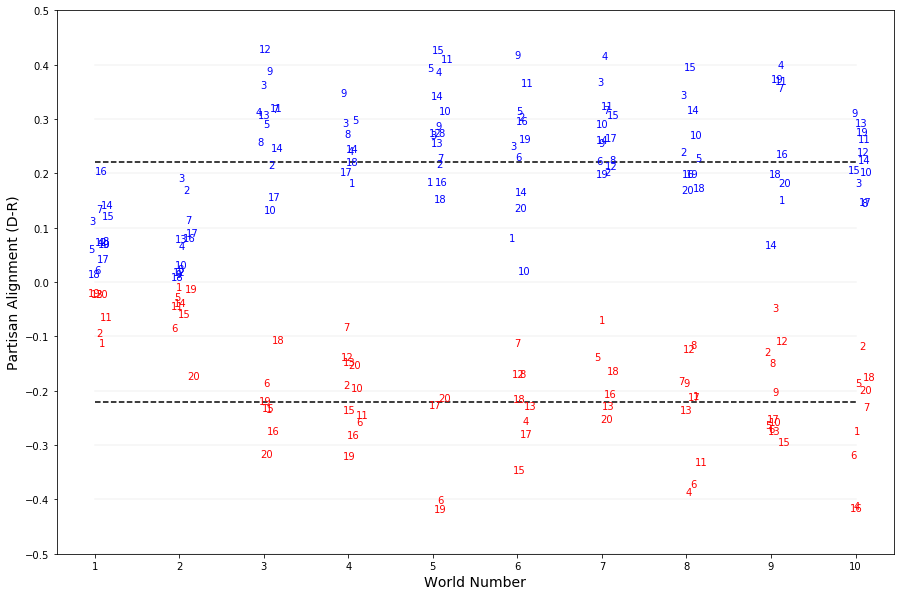

In [46]:
'''
Let's plot the results!
'''

import random

plt.figure(figsize=(15,10))

#Plot grid lines
for i in np.arange(-.5,.6,.1):
    plt.plot([1,10],[i,i], color='k', alpha=0.04)

#Plot Significance Lines
plt.plot([1,10],[.22,.22], color='k', linestyle='--')
plt.plot([1,10],[-.22,-.22], color='k', linestyle='--')
    
#For each world-question pair, plot their partisan difference
for w in range(1,11):
    for q in range(1,21):
        
        #Check the color we will plot (positive values mean democrats support more)
        if wq_results_dict[w][q]['delta_agree'] > 0:
            color = 'blue'
        else:
            color = 'red'
        
        #Plot the Question # of the world-question pair at (X,Y) = (World, Partisan Difference)
        plt.text(x=w + random.uniform(-.1, .1), #Add random horizontal jitter for legibility
                 y=wq_results_dict[w][q]['delta_agree'],
                 s=str(q),
                 color=color)

#Set the limits and the ticks
plt.ylim(-.5,.5)
plt.yticks(np.arange(-.5,.6,.1))
plt.xticks(range(1,11))

#Set the Labels
plt.ylabel('Partisan Alignment (D-R)',size=14)
plt.xlabel('World Number',size=14)


plt.show()

** Original Figure (For Comparison)**

<img src="results_duplicate_img/fig2.png" alt="Drawing" style="width:1000px;"/>

## Figure 3

**_Effect of social Influence on the unpredictability of partisan alignment._**

_The Y-axis measures unpredictability using three indicators: a change in the party more likely to agree and whether one or both parties switched sides on an issue. The measures for each item were averaged over 28 pairs of eight worlds in the influence condition (N=560) and over 1000 random splits of the 463 participants in the independence condition into two worlds of equal size. The results challenge the intuition that large partisan disagreements reflect deeper underlying ideological differences in the intrinsic appeal of political opinions. Recall Figure 1b showing that partisan alignments were nearly three times stronger in the influence condition compared to the independence condition. Figure 3 shows that the alignments are nevertheless more unpredictable as well, due to the sensitivity of cascades to chance variation in the opinions of early movers._

Original Figure (For Comparison)

<img src="results_duplicate_img/fig3.png" alt="Drawing" style="width: 1000px;"/>

## Figure 4a

**_The unpredictability of partisan alignment._**

**_Panel A_** _plots the partisan alignment on each question in each of the eight independence worlds (Y-axis) and the alignment in the influence condition (X-axis). Alignment is measured as the proportion of Democrats who agree on an item minus the proportion of Republicans. The slope of the quadratic estimate indicates that intrinsic ideological attraction to an issue can bias the cascade in a predictable direction (r=.18)._

In [61]:
'''
Figure 4A plots the partisan alignment of prior preferences of each question (independence condition)
against the resulting partisan alignment in each world (influence condition)
'''

#Get the prior %agreement for each question & each party in the independence condition
#Since worlds 1 & 2 are both independent, we can combine them together.
ind_data = answer_data[answer_data['world']<=2].copy()
ind_data['pol_bin'] = ind_data['pol'].apply(lambda x: 1 if x > 0 else -1) #Binarize political values
ind_data = ind_data.groupby(['question','pol_bin']).mean()['response'] #Get 

#Now get the %agreement for each party in each world-question pair.
inf_data = answer_data[answer_data['world']>2].copy()
inf_data['pol_bin'] = inf_data['pol'].apply(lambda x: 1 if x > 0 else -1)
inf_data = inf_data.groupby(['world','question','pol_bin']).mean()['response']


#Re-organize the data into plottable form, such that:
x = [] #aka, the PRIOR partisan difference for each question
y = [] #aka, what partisan difference is for a question in a given world
w_list = [] #aka what world that partisan difference belonged to.

for w in range(3,11):
    for q in range(1,21):
        x += [ind_data[q][-1]-ind_data[q][+1]]
        y += [inf_data[w][q][-1]-inf_data[w][q][+1]]
        w_list += [w]

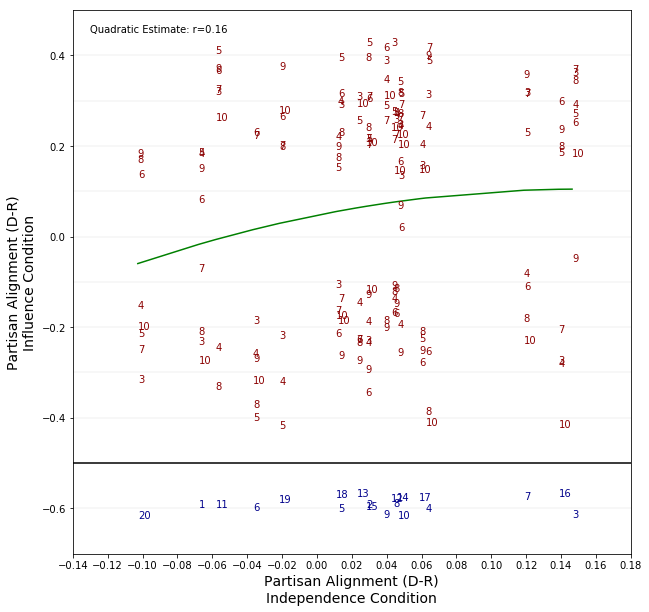

In [63]:
'''
Plot the results!
'''
plt.figure(figsize=(10,10))

#Plot line which seperates out independent alignments
plt.plot([-.14,.2],[-.5,-.5], color='k')

#Plot Gridlines
for i in np.arange(-.6,.5,.1):
    plt.plot([-.14,.18],[i,i], color='k', alpha=0.04)

#Plot Independence World Values
for i in range(20):
    plt.text(x[i],-.6+random.uniform(-.03,.03),str(i+1),color='darkblue') #add random vertical jitter for legibility

#Plot the Resulting partisan difference of each question in each world, 
#X=Prior partsian difference, Y=Specific Influence-world partisan difference, Text=world #
for i in range(len(x)):
    plt.text(x[i],y[i],str(w_list[i]),color='darkred')
    
#Get & Plot Quadratic Function
a = np.polyfit(x,y,deg=2)
y_fit = [a[0]*v**2 + a[1]*v + a[2] for v in x]
b = pd.DataFrame([x,y_fit]).transpose().sort_values(0)
plt.plot(b[0],b[1],color='green')

##Get R^2 & Print It
r = (np.sum([(y_fit[i] - np.mean(y))**2 for i in range(20)]) / 
     np.sum([(y[i]     - np.mean(y))**2 for i in range(20)]) ) ** 0.5
plt.text(-.13,0.45,'Quadratic Estimate: r='+str(round(r,2)))
    
#Set Plot Size and Ticks
plt.xlim(-.14,.18)
plt.ylim(-.7,.5)
plt.xticks(np.arange(-.14,.2,.02))

#Set Labels
plt.xlabel('Partisan Alignment (D-R)\nIndependence Condition', size=14)
plt.ylabel('Partisan Alignment (D-R)\nInfluence Condition', size=14)
    
plt.show()

** Original Figure (For Comparison)**

<img src="results_duplicate_img/fig4a.png" alt="Drawing" style="width: 700px;"/>

## Figure 4b


**_The unpredictability of partisan alignment._**

**_Panel B_** _plots the partisan alignment on each question in each of the eight independence worlds among those who followed the first ten movers (Y-axis) and the alignment among the first ten movers (X-axis). Comparison of the two panels shows how the influence of the first ten movers (r = .67) can outweigh the effects of intrinsic ideological appeal (r = .18)._

In [54]:
'''
Figure 4B plots the mean partisan differences of the first 10 responses for each question in each world (X) 
against the mean partisan differences of the remaining responses in that world (Y). 

We then calculate the correlation between the two and compare them to the correlation of 
the intial prior preferences (Figure 4A)

'''

#Get influence-condition worlds only and get a binarized political column.
wq_data = answer_data[answer_data['world'] > 2].copy()
wq_data['pol_bin'] = wq_data['pol'].apply(lambda x: 1 if x > 0 else -1)


i = 10 #First-i users vs. remaining users. We set this to 10 for our chart
x = [] #List of (%agreement of democrats - %agreement of republicans) of first 10 users for each world-question pair
y = [] #List of (%agreement of democrats - %agreement of republicans) of remaining users for each world-question pair
w_list = [] #List keeping track of the world of each world-question pair

for w in range(3,11):
    for q in range(1,21):
        #Filter on the specific world/question pair & sort by answer order
        wq_data_filter = wq_data[(wq_data['world']==w) & (wq_data['question'] == q)].sort_values('wq_order')

        #Get the first i and remaining users into seperate dataframes.
        wq_data_Fi= wq_data_filter.iloc[:i]
        wq_data_Remain= wq_data_filter.iloc[i:]

        #Get this world/question pair's partisan agreement difference for the first 10 users
        x += [wq_data_Fi[wq_data_Fi['pol_bin'] == -1]['response'].mean() - 
                       wq_data_Fi[wq_data_Fi['pol_bin'] == +1]['response'].mean()]

        #Get this world/question pair's partisan agreement difference for the remaining users
        y += [wq_data_Remain[wq_data_Remain['pol_bin'] == -1]['response'].mean() - 
                        wq_data_Remain[wq_data_Remain['pol_bin'] == +1]['response'].mean()]
        
        w_list += [w]

#Fit a quadratic line on the X-Y pairings above
coefs = np.polyfit(x,y,deg=2)
y_fit = [coefs[0]*v**2 + coefs[1]*v + coefs[2] for v in x]

#Calculate an r-value based on y_fit
r = (np.sum([(y_fit[i] - np.mean(y))**2 for i in range(len(y_fit))]) / 
     np.sum([(y[i]     - np.mean(y))**2 for i in range(len(y_fit))]) ) ** 0.5


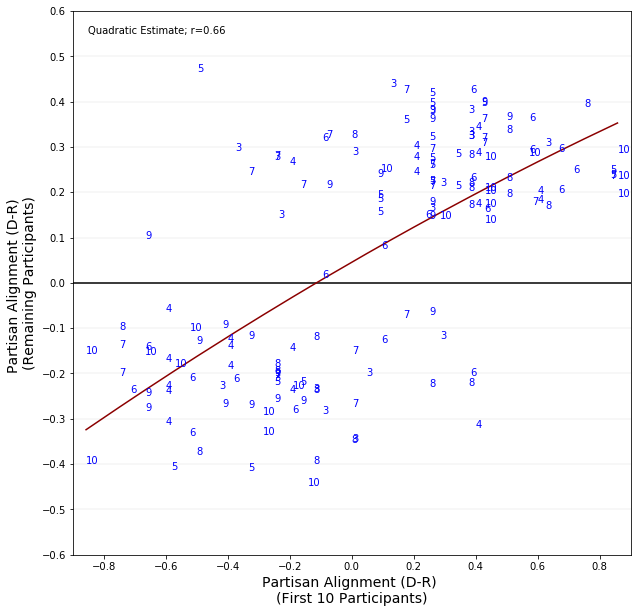

In [58]:
'''
Now let's plot the results!
'''
plt.figure(figsize=(10,10))

#Plot the partisan difference of the first 10 (X), and remaining users (Y) 
#for each question in each world (displayed text)
for i in range(len(x)):
    plt.text(x[i],y[i],str(w_list[i]),color='b')

#Plot gridlines
for i in np.arange(-.5,.6,.1):
    plt.plot([-.9,.9],[i,i], color='k', alpha=0.04)
plt.plot([-.9,.9],[0,0], color='k')

#Plot fitted line
b = pd.DataFrame([x,y_fit]).transpose().sort_values(0)
plt.plot(b[0],b[1],color='darkred')

#Set ticks and limits
plt.xticks(np.arange(-.8,.9,.2))
plt.yticks(np.arange(-.6,.7,.1))
plt.xlim(-.9,.9)
plt.ylim(-.6,.6)

#Set Labels
plt.xlabel('Partisan Alignment (D-R) \n(First 10 Participants)', size=14)
plt.ylabel('Partisan Alignment (D-R) \n(Remaining Participants)',size=14)

#Print r value
plt.text(-.85,.55,'Quadratic Estimate; r='+str(round(r,2)))

plt.show()

** Original Figure (For Comparison)**

<img src="results_duplicate_img/fig4b.png" alt="Drawing" style="width: 700px;"/>